# Práctica 4 Visión por Computador
## Autores:
- Héctor Wood Santana
- Alejandro Viera Ruiz 

## Tarea:

Para la entrega de esta práctica, la tarea consiste en desarrollar un prototipo que procese uno (vídeo ejemplo proporcionado) o varios vídeos (incluyendo vídeos de cosecha propia):
- detecte y siga las personas y vehículos presentes
- detecte y lea las matrículas de los vehículos presentes
- cuente el total de cada clase
- vuelque a disco un vídeo que visualice los resultados
- genere un archivo csv con el resultado de la detección y seguimiento. Se sugiere un formato con al menos los siguientes campos:

        fotograma, tipo_objeto, confianza, identificador_tracking, x1, y1, x2, y2, matrícula_en_su_caso, confianza, mx1,my1,mx2,my2, texto_matricula

La entrega del cuaderno o cuadernos se hace efectiva a través del campus virtual por medio de un enlace github. Además del archivo README, debe incluirse el resultado del vídeo proporcionado como test (o enlace al mismo), y el correspondiente archivo csv. En el caso de entrenarse algún detector, por ejemplo de matrículas, debe proporcionarse acceso al conjunto de datos.

Se considerarán extras:
- Determine el flujo de personas y vehículos en el vídeo de test en distintas direcciones (vehículos que dejan la imagen por la derecha, por la izquierda, etc.)
- Participar en
- Evaluar dos alternativas para la detección de matrículas: basada en YOLO, y basada en contornos.
- Anonimizar a las personas y vehículos presentes en un vídeo.

In [1]:
import cv2  
import math 
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import re
import pandas as pd

from ultralytics import YOLO
from collections import defaultdict

In [3]:
# Modelo de yolo que se usará para la detección de vehículos y personas.
model = YOLO('yolo11n.pt')

A continuación se añade seguimiento a la detección del modelo base. (*Tracking*)

In [4]:
# Video de prueba
filename = "TUD-Crossing.webm"

# Seguimiento, con persistencia entre fotogramas
results = model.track(filename, persist=True, show=True, classes=[0,1,2,3])
cv2.destroyAllWindows()



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/201) c:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\TUD-Crossing.webm: 480x640 6 persons, 1 car, 63.0ms
video 1/1 (frame 2/201) c:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\TUD-Crossing.webm: 480x640 6 persons, 1 car, 15.0ms
video 1/1 (frame 3/201) c:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\TUD-Crossing.webm: 480x640 6 persons, 1 car, 11.5ms
video 1/1 (frame 4/201) c:

Hasta ahora, es posible reconocer los distintos vehículos así como las personas que aparecen en el video. Sin embargo, el modelo no está entrenado para reconocer las placas de matrículas (*license plates*). Por lo tanto, a continuación, se procede a reentrenar el modelo para detectar las matrículas como una nueva clase, cuya etiqueta asignada será *"license-plate"*.

In [6]:
#Entrenamiento de modelo con dataset propio
model.train(data="custom_dataset.yml", epochs=30, imgsz=416, device=0)

New https://pypi.org/project/ultralytics/8.3.24 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.19  Python-3.12.7 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=custom_dataset.yml, epochs=30, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

100%|██████████| 755k/755k [00:00<00:00, 1.19MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 319 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed 


train: Scanning C:\Users\hecto\Documents\Estudios\Universidad\4º\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\labels... 2718 images, 60 backgrounds, 0 corrupt: 100%|██████████| 2718/2718 [00:06<00:00, 437.71it/s]

train: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.72c6c419a82a4ae7826e8e13ceb0b659.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.8e448f6780c3a3575ab3efe9336f621d.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\JR-9568_png.rf.a79073a624fa19d50c6d813eaf3aaaa0.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\LC-1812_png.rf.07d8f14bfe8f38a37c4b76682d22f112.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\images\LC-1812_png.rf.cf2225fa787499903df2

train: New cache created: C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\train\labels.cache


val: Scanning C:\Users\hecto\Documents\Estudios\Universidad\4º\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\valid\labels... 255 images, 5 backgrounds, 1 corrupt: 100%|██████████| 256/256 [00:01<00:00, 219.67it/s]

val: WARNING  C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\valid\images\trailer-containerchassi-trailer-AMT-Trailer-AMT-AO360-Overforingsanhnger-6-0-6-5-m-1663110929206963599_big-22091402152604885100_jpg.rf.f75c5d125d19890fb9cfa73d58764498.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: 'C:\\Users\\hecto\\Documents\\Estudios\\Universidad\\4\\VC\\VC\\VC\\Practica_4\\datasets\\registrringsnummerv12i\\valid\\images\\trailer-containerchassi-trailer-AMT-Trailer-AMT-AO360-Overforingsanhnger-6-0-6-5-m-1663110929206963599_big-22091402152604885100_jpg.rf.f75c5d125d19890fb9cfa73d58764498.jpg'
val: New cache created: C:\Users\hecto\Documents\Estudios\Universidad\4\VC\VC\VC\Practica_4\datasets\registrringsnummerv12i\valid\labels.cache


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       1.1G     0.8457      1.221     0.9948         38        416: 100%|██████████| 170/170 [00:28<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]

                   all        255        263      0.933      0.916       0.96      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.08G      0.842     0.7121     0.9749         35        416: 100%|██████████| 170/170 [00:24<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]

                   all        255        263      0.931       0.92      0.929      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.08G     0.8165     0.6319     0.9699         38        416: 100%|██████████| 170/170 [00:24<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        255        263      0.325      0.932      0.418      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.08G     0.7842     0.5812      0.958         33        416: 100%|██████████| 170/170 [00:24<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        255        263      0.958      0.935      0.956       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.08G     0.7742      0.549     0.9575         31        416: 100%|██████████| 170/170 [00:25<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]

                   all        255        263      0.957      0.966      0.977      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.08G     0.7171     0.5056     0.9435         38        416: 100%|██████████| 170/170 [00:24<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        255        263      0.921      0.954      0.976        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.08G     0.7112     0.4967     0.9394         40        416: 100%|██████████| 170/170 [00:27<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        255        263      0.926      0.951      0.971      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.08G     0.6692     0.4704      0.934         35        416: 100%|██████████| 170/170 [00:27<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

                   all        255        263       0.94       0.96      0.969      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.08G     0.6646     0.4672     0.9292         39        416: 100%|██████████| 170/170 [00:26<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

                   all        255        263      0.919      0.953      0.967      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.08G     0.6558     0.4548     0.9284         36        416: 100%|██████████| 170/170 [00:26<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]

                   all        255        263      0.955      0.958      0.974      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.08G     0.6391     0.4437     0.9226         33        416: 100%|██████████| 170/170 [00:27<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

                   all        255        263      0.944       0.97      0.975      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.08G     0.6289      0.427     0.9213         41        416: 100%|██████████| 170/170 [00:26<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        255        263      0.964       0.97      0.975      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.09G     0.6155     0.4246      0.918         32        416: 100%|██████████| 170/170 [00:25<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]

                   all        255        263      0.941       0.97      0.975      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.08G     0.5985     0.4146     0.9125         39        416: 100%|██████████| 170/170 [00:26<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]

                   all        255        263      0.958       0.97      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.08G     0.5913      0.407     0.9112         41        416: 100%|██████████| 170/170 [00:26<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]

                   all        255        263      0.952       0.97      0.977      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.08G     0.5708     0.3913     0.9103         31        416: 100%|██████████| 170/170 [00:26<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]

                   all        255        263      0.933      0.981      0.976      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.08G     0.5735      0.389     0.9077         45        416: 100%|██████████| 170/170 [00:27<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        255        263      0.955      0.979      0.971      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.08G     0.5641     0.3925     0.9092         41        416: 100%|██████████| 170/170 [00:27<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        255        263      0.966      0.985      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.09G     0.5481      0.375     0.9012         41        416: 100%|██████████| 170/170 [00:27<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        255        263      0.962      0.974      0.979      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.08G     0.5296     0.3626     0.8961         30        416: 100%|██████████| 170/170 [00:29<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

                   all        255        263      0.963      0.985      0.984      0.825


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.08G     0.5216     0.3538     0.8687         13        416: 100%|██████████| 170/170 [00:26<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        255        263      0.945      0.984      0.976      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.08G     0.4869     0.3387     0.8654         14        416: 100%|██████████| 170/170 [00:26<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        255        263       0.94      0.989      0.978      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.08G     0.4876     0.3318     0.8677         13        416: 100%|██████████| 170/170 [00:23<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        255        263      0.959      0.992       0.98      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.08G      0.456     0.3175     0.8562         14        416: 100%|██████████| 170/170 [00:24<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        255        263      0.966      0.985       0.98      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.08G     0.4573     0.3088     0.8527         15        416: 100%|██████████| 170/170 [00:24<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]

                   all        255        263      0.959      0.974       0.98      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.08G     0.4209     0.2902      0.849         14        416: 100%|██████████| 170/170 [00:26<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

                   all        255        263      0.959      0.989      0.979      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.08G     0.4111     0.2791     0.8509         13        416: 100%|██████████| 170/170 [00:24<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all        255        263      0.972      0.989      0.979      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.08G     0.4005     0.2724     0.8473         14        416: 100%|██████████| 170/170 [00:28<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        255        263      0.974      0.984      0.979      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.08G     0.3827     0.2618      0.839         30        416: 100%|██████████| 170/170 [00:27<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        255        263      0.959       0.99      0.977      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.07G     0.3705     0.2519     0.8432         14        416: 100%|██████████| 170/170 [00:27<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

                   all        255        263      0.967       0.99      0.978      0.894



30 epochs completed in 0.255 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.4MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.19  Python-3.12.7 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


                   all        255        263      0.974      0.991       0.98      0.901
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001B7A3A603B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Se muestra la matriz de confusión resultante:

(np.float64(-0.5), np.float64(2999.5), np.float64(2249.5), np.float64(-0.5))

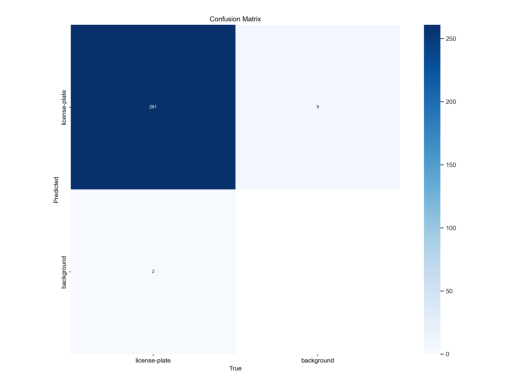

In [5]:
# Carga del modelo con mejor resultado tras el entrenamiento:
cm = cv2.imread("./runs/detect/train3/confusion_matrix.png")
cm = cv2.cvtColor(cm, cv2.COLOR_BGR2RGB)

plt.imshow(cm)
plt.axis('off')

Finalmente, para lograr el objetivo de la práctica, se usa el modelo base 'yolo11n.pt' en conjunto con el modelo entrenado con mejores resultados 'best.pt', para detectar los coches dentro de un video y extraer sus matrículas.

In [ ]:
#Cargar los modelos a utilizar para la detección de clases
det_vehicles = YOLO("yolo11n.pt")
det_plates = YOLO("runs/detect/train3/weights/best.pt")


#Ruta al ejecutable de Tesseract OCR
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract' # "C:/Program Files/Tesseract-OCR/tesseract" o "D:/Programs/Tesseract-OCR/tesseract.exe"

# Etiqueta de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus"]

vid = 'C0142.MP4'
cap = cv2.VideoCapture(vid)

track_history = defaultdict(lambda: [])

while(True):      
    #Fotograma a fotograma
    ret, img = cap.read()
  
    #Si hay imagen válida
    if ret:  
        #Seguimiento, con persistencia entre fotogramas
        results = det_vehicles.track(img, persist=True, classes = [0, 2, 3, 5])

        
        if 0:
            if results is not None:
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()
                annotated_frame = results[0].plot()
                for box, track_id in zip(boxes, track_ids):
                    x, y, w, h = box
                    track = track_history[track_id]
                    track.append((float(x), float(y)))
                    if len(track) > 30:
                        track.pop(0)
                    points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                    cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)
                cv2.imshow("YOLO11 Tracking", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        

        
        #Para cada detección
        for r in results:
            boxes = r.boxes

            for box in boxes:
                #Contenedor
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
                if (box.cls == 2) and (box.conf[0] > 0.7):
                    vehicle_crop = img[y1:y2, x1:x2]  # Recorte del área del vehículo

                    #Detección de matrículas en el recorte del vehículo
                    plate_results = det_plates(vehicle_crop)

                    #Procesar detecciones de matrículas
                    for plate in plate_results[0].boxes:
                        px1, py1, px2, py2 = map(int, plate.xyxy[0])

                        #Ajustar coordenadas al espacio de la imagen original
                        abs_x1, abs_y1 = x1 + px1, y1 + py1
                        abs_x2, abs_y2 = x1 + px2, y1 + py2

                        #Recorte de la matrícula y reconocimiento de texto con Tesseract
                        plate_crop = vehicle_crop[py1:py2, px1:px2]
                        plate_text = pytesseract.image_to_string(plate_crop, config='--psm 8')  # OCR

                        plate_text = re.sub('[^A-Za-z0-9]', '', plate_text)

                        #Visualización de bounding box de la matrícula de coche
                        cv2.rectangle(img, (abs_x1, abs_y1), (abs_x2, abs_y2), (0, 255, 0), 1)
                        
                        #Visualización del texto de la matrícula (tesseract)
                        cv2.putText(img, f'Plate: {plate_text}', (abs_x1, abs_y1 - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                        print(f"Matrícula detectada: {plate_text}")  # Imprimir matrícula en consola

                #Etiqueta de seguimiento
                if box.id is not None:
                    track_id = str(int(box.id[0].tolist()))
                else:
                    track_id = ''
                
                # Confianza
                confidence = math.ceil((box.conf[0]*100))/100
                print("Confianza --->",confidence)

                # Clase
                cls = int(box.cls[0])
                print("Clase -->", classNames[cls])

                # Dibuja el contenedor y clase
                cv2.rectangle(img, (x1, y1), (x2, y2), (127, 127, 127), 3)
                cv2.putText(img, track_id + ' ' + classNames[cls] + ' ' + str(confidence), [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 127), 2)

        # Muestra fotograma
        cv2.imshow('Vid', img)
    
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
cap.release()
# Destruye ventanas
cv2.destroyAllWindows()




0: 384x640 1 car, 1 bus, 23.7ms
Speed: 5.0ms preprocess, 23.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 320x416 (no detections), 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 416)
Confianza ---> 0.85
Clase --> car

0: 384x640 1 car, 1 bus, 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 384x640 1 car, 1 bus, 25.2ms
Speed: 3.0ms preprocess, 25.2ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 12.7ms
Speed: 4.0ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 384

In [9]:
# TEST DE HECTOR

#Cargar los modelos a utilizar para la detección de clases
det_vehicles = YOLO("yolo11n.pt")
det_plates = YOLO("runs/detect/train3/weights/best.pt")

#Ruta al ejecutable de Tesseract OCR
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract' # "C:/Program Files/Tesseract-OCR/tesseract" o "D:/Programs/Tesseract-OCR/tesseract.exe"

# Etiqueta de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus"]

# Contenedores para resultados
detections_data = []

# Video de entrada
vid = 'C0142.MP4'
cap = cv2.VideoCapture(vid)

# Configuración del video de salida
output_vid = "video_salida.avi"
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_vid, fourcc, fps, (width, height))

# Variables globales de contador
person_counter = 0
car_counter = 0
motorbike_counter = 0
bus_counter = 0

# Conjunto para almacenar IDs ya contados
counted_ids = set()

# Clase para modificar los contadores
def count_class(class_ID, object_ID):
    global person_counter, car_counter, motorbike_counter, bus_counter  # Declaración de variables globales
    
    if object_ID not in counted_ids:
        if class_ID == classNames.index("car"):
            car_counter += 1
            counted_ids.add(object_ID)  # Agrega el ID al conjunto de contados
        elif class_ID == classNames.index("person"):
            person_counter += 1
            counted_ids.add(object_ID)  # Agrega el ID al conjunto de contados
        elif class_ID == classNames.index("motorbike"):
            motorbike_counter += 1
            counted_ids.add(object_ID)  # Agrega el ID al conjunto de contados
        elif class_ID == classNames.index("bus"):
            bus_counter += 1
            counted_ids.add(object_ID)  # Agrega el ID al conjunto de contados

frame_id = 0

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    results = det_vehicles.track(img, persist=True, classes = [0, 2, 3, 5])

    #Para cada detección
    for r in results:
        boxes = r.boxes

        for box in boxes:
            #Contenedor
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
            
            # Si la detección es una persona (clase "person")
            if box.cls == 0:
                # Aplicar desenfoque para anonimizar la persona
                person_crop = img[y1:y2, x1:x2]
                person_crop = cv2.blur(person_crop, (30, 30))  # Desenfoque de mosaico
                img[y1:y2, x1:x2] = person_crop

            plate_text = ''

            # Si la detección es un coche.
            if (box.cls == 2) and (box.conf[0] > 0.7):
                vehicle_crop = img[y1:y2, x1:x2]  # Recorte del área del vehículo

                #Detección de matrículas en el recorte del vehículo
                plate_results = det_plates(vehicle_crop)
                

                #Procesar detecciones de matrículas
                for plate in plate_results[0].boxes:
                    px1, py1, px2, py2 = map(int, plate.xyxy[0])

                    #Ajustar coordenadas al espacio de la imagen original
                    abs_x1, abs_y1 = x1 + px1, y1 + py1
                    abs_x2, abs_y2 = x1 + px2, y1 + py2

                    # Verificar que las coordenadas del recorte estén dentro de los límites de vehicle_crop
                    height, width = vehicle_crop.shape[:2]
                    px1 = max(0, px1)
                    py1 = max(0, py1)
                    px2 = min(width, px2)
                    py2 = min(height, py2)

                    #Recorte de la matrícula y reconocimiento de texto con Tesseract
                    plate_crop = vehicle_crop[py1:py2, px1:px2]
                    
                    # Comprobar que el recorte no esté vacío y tenga dimensiones válidas
                    if plate_crop.shape[0] > 0 and plate_crop.shape[1] > 0:
                        # Convertir a escala de grises para mejorar el reconocimiento
                        plate_crop_gray = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
                        
                        # Obtenemos los contornos con Canny
                        canny_img = cv2.Canny(plate_crop_gray, 100, 200)

                        plate_text = pytesseract.image_to_string(canny_img, config='--psm 8')  # OCR
                        plate_text = re.sub('[^A-Za-z0-9]', '', plate_text)

                        # Anonimizar la matrícula aplicando desenfoque en lugar de mostrar el texto
                        plate_crop_blur = cv2.blur(plate_crop, (15, 15))
                        vehicle_crop[py1:py2, px1:px2] = plate_crop_blur
                    else:
                        plate_text = ""

                    #Visualización de bounding box de la matrícula de coche
                    cv2.rectangle(img, (abs_x1, abs_y1), (abs_x2, abs_y2), (0, 255, 0), 1)
                    
                    #Visualización del texto de la matrícula (tesseract)
                    cv2.putText(img, f'Plate: {plate_text}', (abs_x1, abs_y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    print(f"Matrícula detectada: {plate_text}")  # Imprimir matrícula en consola

            #Etiqueta de seguimiento
            if box.id is not None:
                track_id = str(int(box.id[0].tolist()))
            else:
                track_id = ''

            # Confianza
            confidence = math.ceil((box.conf[0]*100))/100
            print("Confianza --->",confidence)

            # Clase
            cls = int(box.cls[0])
            print("Clase -->", classNames[cls])

            # Dibuja el contenedor y clase
            cv2.rectangle(img, (x1, y1), (x2, y2), (127, 127, 127), 3)
            cv2.putText(img, track_id + ' ' + classNames[cls] + ' ' + str(confidence), [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 127), 2)

            # Modificacion de los contadores
            track_id_count = int(box.id[0])
            count_class(int(box.cls[0]), track_id_count)

            #Lista de datos
            detections_data.append({
                "frame": frame_id,
                "type": classNames[cls],
                "confidence": confidence,
                "tracking_id": track_id,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "license_plate_text": plate_text if plate_text else "-1",
                "lp_x1": x1, "lp_y1": y1, "lp_x2": x2, "lp_y2": y2,
                "lp_confidence": confidence if plate_text else "-1"
            })

    out.write(img)
    frame_id+=1

print("Cantidad de objetos encontrados por clase:")
print("Persona:", person_counter)
print("Coche:", car_counter)
print("Moto:", motorbike_counter)
print("Guagua:", bus_counter)


cap.release()
out.release()

df = pd.DataFrame(detections_data)
df.to_csv("detecciones.csv", index=False)


0: 384x640 1 car, 1 bus, 23.0ms
Speed: 4.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 320x416 (no detections), 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 416)
Confianza ---> 0.85
Clase --> car

0: 384x640 1 car, 1 bus, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 384x640 1 car, 1 bus, 20.0ms
Speed: 4.0ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Confianza ---> 0.94
Clase --> bus

0: 352x416 (no detections), 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 416)
Confianza ---> 0.82
Clase --> car

0: 384